# pyGMs Introduction: Monte Carlo Approximations

In [1]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt

... Monte Carlo estimators and sampling ...

### <span style="color:red"> TODO: lots </span>

### Example Model

Let us first build a simple graphical model on which to perform our inference tasks:

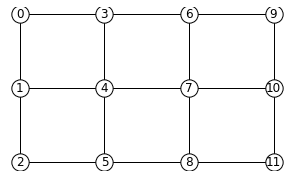

In [2]:
h,w = 3,4
X = [gm.Var(i,3) for i in range(h*w)]
tab = np.array([[1,0,0],[0,.9,0],[0,0,.8]])+.1
factors  = [gm.Factor([X[h*i+j],X[h*i+j+1]],tab) for i in range(w) for j in range(h-1)]
factors += [gm.Factor([X[h*i+j],X[h*i+j+h]],tab) for i in range(w-1) for j in range(h)]

pos = {i:(i//h,-(i%h)) for i in range(h*w)}

model = gm.GraphModel(factors)

order = list(range(w*h))            # default elimination order

fig,ax=plt.subplots(1,1,figsize=(5,3)); ax.set_axis_off();
gm.drawMarkovGraph(model,node_color='w',ax=ax, pos=pos);

In [3]:
def d2t(dict_cfg,n):
    tup_cfg = tuple(dict_cfg.get(i,np.nan) for i in range(n))
    return tup_cfg

### Sampling-based estimators
If we can generate exact samples from a distribution, we can use empirical frequncies to estimate values:

In [11]:
import pyGMs.wmb

jt = gm.wmb.JTree(model, order,'sum+')   # do the work to find f(x)'s normalized sampling distribution

samples = [d2t(jt.sample()[0],w*h) for s in range(100)]  # draw samples

beliefs = gm.misc.empirical( [ [X[0]], [X[3],X[4]] ] , samples, normalize=True)  # estimate frequencies

print('p(X0) ~ ',beliefs[0].table)
print('p(X3,X4) ~ ',beliefs[1].table)

p(X0) ~  [0.83 0.14 0.03]
p(X3,X4) ~  [[0.84 0.   0.  ]
 [0.   0.14 0.  ]
 [0.   0.   0.02]]


### Basic sampling estimators

If we do not want to compute the exact $p(X)$ -- for example, if the graph has high width -- we can define a simpler proposal and use an importance sampling estimator.  Since sampling operators return both a configuration $x$ and the probability of generating $x$, a basic importance sampler is easy:

We first create an easy-to-sample-from distribution.  In this case, we will just select a tree-structured sub-graph of our full model. (Alternatively, we could get a distribution from weighted mini-bucket (WMB), for example.)

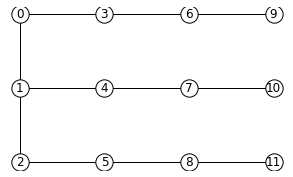

In [5]:
span_tree = factors[:h-1] + factors[w*(h-1):]
tree_submodel = gm.GraphModel(span_tree)
tree_order,_ = gm.eliminationOrder(tree_submodel, 'minwidth')
proposal = gm.wmb.JTree(tree_submodel, tree_order, 'sum+')  # tree is only width 1

fig,ax=plt.subplots(1,1,figsize=(5,3)); ax.set_axis_off();
gm.drawMarkovGraph(tree_submodel,node_color='w',ax=ax, pos=pos);

The importance sampling estimator draws samples $x\sim q(X)$, and assigns them an importance weight given by $w = f(x)/q(x)$.  Then, we can estimate queries using these weighted samples.  A common estimator is the self-normalized importance sampler, in which we collect the weights, normalize them, and then use the weighted empirical expectations for our queries:

In [10]:
draws = [ (x,model.logValue(x)-wt) for s in range(100) for x,wt in [proposal.sample()] ]
samples, log_weights = [d2t(x,w*h) for x,wt in draws], [wt for x,wt in draws]

weights_selfnorm = np.exp( np.array(log_weights) );
weights_selfnorm /= weights_selfnorm.sum()

beliefs = gm.misc.empirical( [ [X[0]], [X[3],X[4]] ] , samples, weights_selfnorm)  # estimate frequencies

print('p(X0) ~ ',beliefs[0].table)
print('p(X3,X4) ~ ',beliefs[1].table)

p(X0) ~  [0.83735772 0.11969859 0.04294369]
p(X3,X4) ~  [[8.36628960e-01 1.21259691e-04 2.74649625e-05]
 [1.19487636e-03 1.15319358e-01 2.78035716e-05]
 [9.39452211e-05 3.76243650e-03 4.28238963e-02]]


We can see this is reasonably accurate compared to the exact sampler with a similar number of draws.

### Query Structures

More generally, Monte Carlo estimators run in an any-time manner...

We define a "Query" structure to capture what information we would like to retain from the state vector; then we can pass this into a sampling procedure (importance sampling, Markov chain Monte Carlo, etc.) and let it run while it updates and saves only the information relevant to the query.

For example, suppose we would like to run Gibbs sampling for 1000 steps, decimating our samples by a factor of 3 and keeping only the last 10 samples:

In [14]:
import pyGMs.montecarlo

query = gm.montecarlo.QuerySamples(keep=10, stride=3)

gm.montecarlo.GibbsSampling(model, query, stopSamples=1000)

print(query())

[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


### <span style="color:red"> TODO: lots </span>